In [1]:
%load_ext autoreload
%autoreload 2

Intersection Over Union Paper
https://arxiv.org/pdf/1608.01471.pdf

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches
from object_loc_helper import get_class_names_map, PlotLosses

Using TensorFlow backend.


In [3]:
data_folder = 'dataset/ILSVRC/Data/CLS-LOC'

In [4]:
annotations_dict_train = np.load('reduced_dataset/annotations_train_5_classes.npy').flat[0]
annotations_dict_val = np.load('reduced_dataset/annotations_val_5_classes.npy').flat[0]

In [5]:
class_ids_list = list(annotations_dict_train.keys())
n_classes = len(class_ids_list)
print(class_ids_list)
print('total clases:', n_classes)

['n04487081', 'n02108089', 'n01751748', 'n02701002', 'n02279972']
total clases: 5


In [6]:
synset_dict = get_class_names_map()
for k, v in synset_dict.items():
    if k in class_ids_list:
        print(k, v)

n01751748 sea snake
n02108089 boxer
n02279972 monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
n02701002 ambulance
n04487081 trolleybus, trolley coach, trackless trolley


n02108089 boxer
Cantidad de imagenes de esta clase: 293


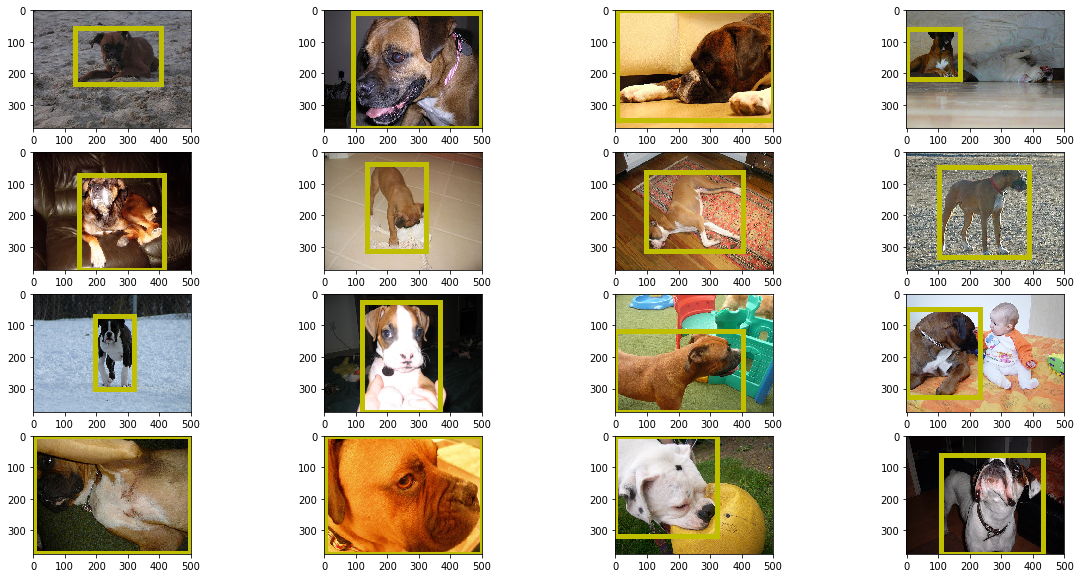

In [7]:
def plot_sample_class(class_index):
    img_class = list(annotations_dict_train.keys())[class_index]
    print(img_class, synset_dict[img_class])
    image_filenames = list(annotations_dict_train[img_class].keys())
    print('Cantidad de imagenes de esta clase:', len(image_filenames))

    fig, axs = plt.subplots(4,4, figsize=(20,10))
    axs = axs.flatten()
    for i, image_file_id in enumerate(image_filenames[:16]):
        image_file = data_folder+'/train/'+img_class+'/' +image_file_id+'.JPEG'
        image = Image.open(image_file)
        axs[i].imshow(image)
        bounding_box = annotations_dict_train[img_class][image_file_id]['bounding_boxes'][0]
        rect = patches.Rectangle(bounding_box[:2],bounding_box[2]-bounding_box[0],bounding_box[3]-bounding_box[1],linewidth=5, edgecolor='y',facecolor='none')
        axs[i].add_patch(rect)
    plt.show()
plot_sample_class(1)

# Armo carpentas con clases

In [8]:
import os
from shutil import copyfile, rmtree

In [9]:
train_folder = 'reduced_dataset/images/train'
val_folder = 'reduced_dataset/images/val'

In [10]:
# Creo carpetas de train y val
if (os.path.isdir(train_folder)):
    rmtree(train_folder)
os.mkdir(train_folder)
if (os.path.isdir(val_folder)):
    rmtree(val_folder)
os.mkdir(val_folder)

In [11]:
# Create classes folders
for class_id in class_ids_list:
    folder_to_create_train = train_folder+'/'+class_id
    folder_to_create_val = val_folder+'/'+class_id
    if (os.path.isdir(folder_to_create_train)):
        rmtree(folder_to_create_train)
    if (os.path.isdir(folder_to_create_val)):
        rmtree(folder_to_create_val)
    os.mkdir(folder_to_create_train)
    os.mkdir(folder_to_create_val)

In [12]:
# Para train
class_list = []
images_file_list = []
for i, (class_id, v) in enumerate(annotations_dict_train.items()):
    for j, image_file_id in enumerate(v):
        image_file = data_folder+'/train/'+class_id+'/' +image_file_id+'.JPEG'
        copyfile(image_file, train_folder+'/'+class_id+'/' +image_file_id+'.JPEG')
    print('class index:',i, 'Total:', j)

class index: 0 Total: 434
class index: 1 Total: 292
class index: 2 Total: 282
class index: 3 Total: 280
class index: 4 Total: 271


In [13]:
# Para val
class_list = []
images_file_list = []
for i, (class_id, v) in enumerate(annotations_dict_val.items()):
    for j, image_file_id in enumerate(v):
        image_file = data_folder+'/val/' +image_file_id+'.JPEG'
        copyfile(image_file, val_folder+'/'+class_id+'/' +image_file_id+'.JPEG')
    print('class index:',i, 'Total:', j)

class index: 0 Total: 30
class index: 1 Total: 25
class index: 2 Total: 32
class index: 3 Total: 38
class index: 4 Total: 29


# Construyo generador custom

In [145]:
from keras.preprocessing.image import ImageDataGenerator

In [728]:
from  keras.utils import Sequence
class GeneratorMultipleOutputs(Sequence):
    def __init__(self, annotations_dict, folder, batch_size, flip = 'no_flip', get_filenames = False):
        # flip = {no_flip, always, random}
        self.flip = flip
        self.get_filenames = get_filenames
        np.random.seed(seed=40)
        self.annotations_dict = annotations_dict
        datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=False)
        self.generator = datagen.flow_from_directory(
            directory=folder,
            target_size=(375, 500),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=42
        )
    def get_image_object_center(self):
        bboxes = []
        batch_index = self.generator.batch_index
        if self.generator.batch_index == 0:
            batch_index = self.__len__()
        batch_filenames = np.array(self.generator.filenames)[self.generator.index_array][(batch_index-1)*self.generator.batch_size:batch_index*self.generator.batch_size]
        #print(self.generator.batch_index, self.generator.total_batches_seen, len(batch_filenames), batch_index)
        for filename in batch_filenames:
            arr = filename.split('/')
            class_id = arr[0]
            image_idx = arr[1].split('.')[0]
            # print(filename, class_id, image_idx)
            bboxes.append(self.annotations_dict[class_id][image_idx]['bounding_boxes'][0])
        bboxes = np.array(bboxes)
        img_width = self.annotations_dict[class_id][image_idx]['width']
        img_height = self.annotations_dict[class_id][image_idx]['height']
        box_width = bboxes[:,2]-bboxes[:,0]
        box_height = bboxes[:,3]-bboxes[:,1]
        centerX = (bboxes[:,0]+(box_width)/2)/img_width
        centerY = (bboxes[:,1]+(box_height)/2)/img_height
        return centerX, centerY, box_width/img_width, box_height/img_height, batch_filenames
    def __len__(self):
        return int(np.ceil(self.generator.samples / float(self.generator.batch_size)))
    def __getitem__(self, idx):
        data = next(self.generator)
        centerX, centerY, width, height, batch_filenames = self.get_image_object_center()
        if self.flip == 'random':
            inices_to_flip = np.random.randint(0, 2, data[0].shape[0]).nonzero()
            data[0][inices_to_flip] = np.flip(data[0][inices_to_flip], axis = 2)
            centerX[inices_to_flip] = 1 - centerX[inices_to_flip]
        elif self.flip == 'always':
            data[0][:] = np.flip(data[0][:], axis = 2)
            centerX = 1 - centerX
        if self.get_filenames:
            return (data[0], [data[1], np.array([centerX, centerY, width, height]).T], batch_filenames)
        else:    
            return (data[0], [data[1], np.array([centerX, centerY, width, height]).T])
    def __next__(self):
        return self.__getitem__(0)
    def __iter__(self):
        return self

Found 1564 images belonging to 5 classes.


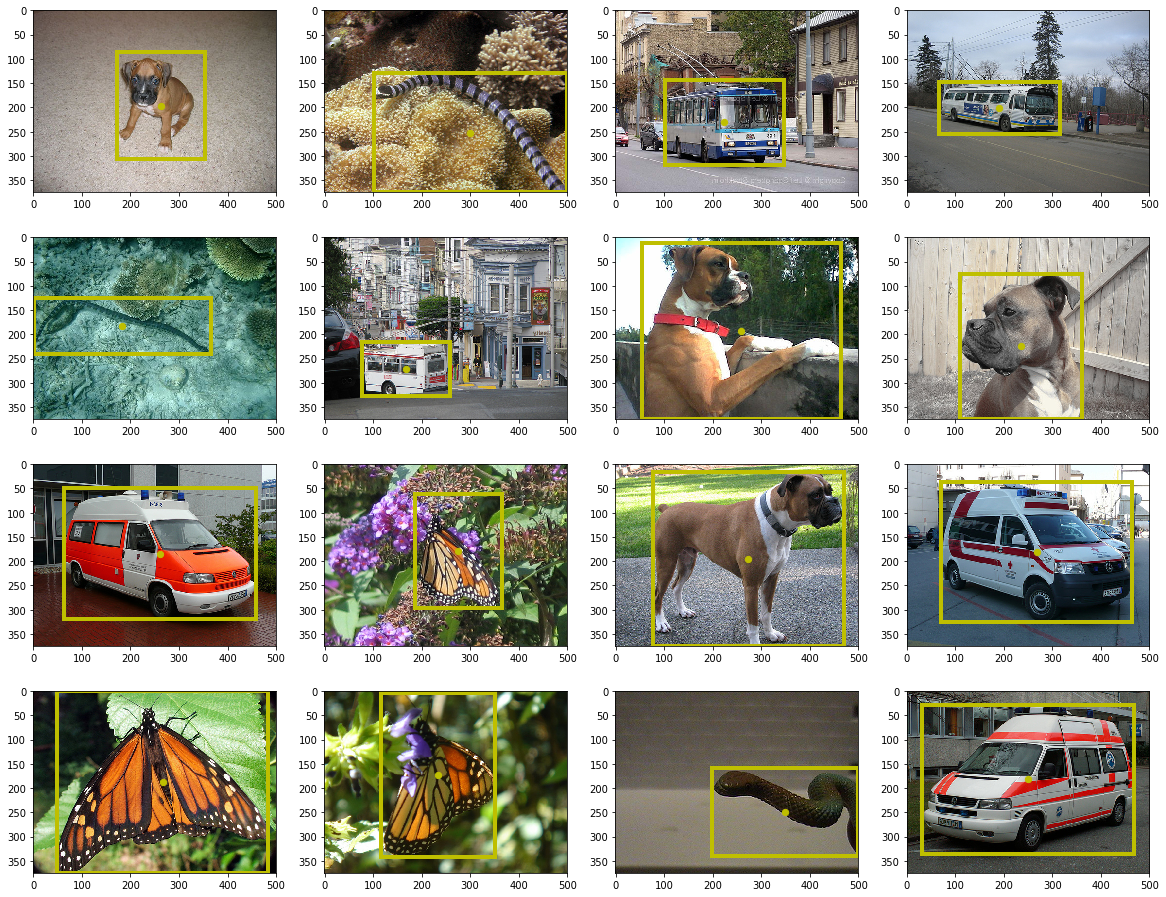

In [738]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 4, flip = 'always')
i = 0
N = 4
f, ax = plt.subplots(N, train_generator_multiple_outputs.generator.batch_size, figsize=(20, 4*N))
for batch in train_generator_multiple_outputs:
    # Estan normalizados
    bounding_boxes = batch[1][1]
    centerX = bounding_boxes[:, 0]
    centerY = bounding_boxes[:, 1]
    width = bounding_boxes[:, 2] 
    height = bounding_boxes[:, 3]
    for j, bat in enumerate(batch[0]):
        ax[i, j].imshow(bat)
        im_w = bat.shape[1]
        im_h = bat.shape[0]
        ax[i, j].scatter(centerX[j]*im_w, centerY[j]*im_h, s= 40, color='y')
        rect = patches.Rectangle(((centerX[j]-width[j]/2)*im_w, (centerY[j]-height[j]/2)*im_h),width[j]*im_w,height[j]*im_h,linewidth=4, edgecolor='y',facecolor='none')
        ax[i, j].add_patch(rect)
    i += 1
    if i >= N:
        break
plt.show()

In [1110]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 64, flip = 'random')
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, val_folder, 159, flip = 'random')

Found 1564 images belonging to 5 classes.
Found 159 images belonging to 5 classes.


In [1067]:
def get_layer(x, filters = 32, filter_size = (3,3), pool_size=(2,2)):
    conv = Conv2D(filters, filter_size)(x)
    BN = BatchNormalization()(conv)
    act = Activation('relu')(BN)
    out = MaxPooling2D(pool_size=pool_size)(act)
    # DO1 = Dropout(0.25)(maxPool1)
    return out

In [1086]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization, Concatenate
from keras.models import Model
from keras.constraints import max_norm
from keras.optimizers import Adam, rmsprop
from keras.callbacks import ModelCheckpoint

def get_simple_model(input_shape=(375, 500, 3)):
    x = Input(shape=(375, 500, 3))
    l1 = get_layer(x, filters = 32, filter_size = (3,3), pool_size=(2,2))
    
    l2 = get_layer(l1, filters = 64, filter_size = (3,3), pool_size=(2,2))
    
    l3 = get_layer(l2, filters = 128, filter_size = (3,3), pool_size=(2,2))
    
    l4 = get_layer(l3, filters = 256, filter_size = (3,3), pool_size=(2,2))
    
    l5 = get_layer(l4, filters = 512, filter_size = (3,3), pool_size=(2,2))

    GAP = GlobalAveragePooling2D()(l5)
    last_layer = Dropout(0.25)(GAP)
    return last_layer, x
last_layer, input_layer = get_simple_model()

In [1087]:
classification = Dense(n_classes, activation='softmax', name='category_output')(last_layer) #kernel_constraint=max_norm(2.)
bounding_box = Dense(4, name='bounding_box')(last_layer)
#regression_center_x = Dense(1, name='center_x')(last_layer)
#regression_center_y = Dense(1, name='center_y')(last_layer)
#regression_width = Dense(1, name='width')(last_layer)
#regression_height = Dense(1, name='height')(last_layer)
#model = Model(inputs=input_layer, outputs=[classification, regression_center_x, regression_center_y, regression_width, regression_height])
model = Model(inputs=input_layer, outputs=[classification, bounding_box])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 373, 498, 32) 896         input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_121 (BatchN (None, 373, 498, 32) 128         conv2d_121[0][0]                 
__________________________________________________________________________________________________
activation_121 (Activation)     (None, 373, 498, 32) 0           batch_normalization_121[0][0]    
__________________________________________________________________________________________________
max_poolin

In [1088]:
from keras import backend as K
def iou(boxA,boxB):
    xA = K.stack([boxA[:,0]-boxA[:,2]/2, boxB[:,0]-boxB[:,2]/2], axis=-1)
    yA = K.stack([boxA[:,1]-boxA[:,3]/2, boxB[:,1]-boxB[:,3]/2], axis=-1)
    xB = K.stack([boxA[:,0]+boxA[:,2]/2, boxB[:,0]+boxB[:,2]/2], axis=-1)
    yB = K.stack([boxA[:,1]+boxA[:,3]/2, boxB[:,1]+boxB[:,3]/2], axis=-1)

    xA = K.max(xA, axis=-1)
    yA = K.max(yA, axis=-1)
    xB = K.min(xB, axis=-1)
    yB = K.min(yB, axis=-1)

    interX = K.zeros_like(xB)
    interY = K.zeros_like(yB)

    interX = K.stack([interX, xB-xA], axis=-1)
    interY = K.stack([interY, yB-yA], axis=-1)

    #because of these "max", interArea may be constant 0, without gradients, and you may have problems with no gradients. 
    interX = K.max(interX, axis=-1)
    interY = K.max(interY, axis=-1)
    interArea = interX * interY

    boxAArea = (boxA[:,2]) * (boxA[:,3])    
    boxBArea = (boxB[:,2]) * (boxB[:,3]) 
    iou = interArea / (boxAArea + boxBArea - interArea)
    return iou

In [1089]:
losses = {"category_output": "categorical_crossentropy", 
          #"center_x": "mean_squared_error", 
          #"center_y": "mean_squared_error",
          #"width": "mean_squared_error",
          #"height": "mean_squared_error",
          "bounding_box": "mean_squared_error"
         }
metrics = {"category_output": "accuracy", 
           #"center_x": "mae", 
           #"center_y": "mae", 
           #"width": "mae", 
           #"height": "mae",
           "bounding_box": [iou, "mae"]
          }
lossWeights = {"category_output": 1.0, 
               "bounding_box":  120.0,
               #"center_x": 30.0,  
               #"center_y": 30.0, 
               #"width": 30.0, 
               #"height": 30.0
              }

In [1111]:
checkpoint = ModelCheckpoint(filepath = 'weights_5_classes_w_30_best_after_final_1000_epochs_do_25_0.0001.hdf5', 
                             monitor='val_category_output_acc', save_best_only=True)
model.compile(loss=losses,
              #optimizer=rmsprop(),
              optimizer=Adam(lr=0.0001),
              metrics=metrics,
              loss_weights = lossWeights)

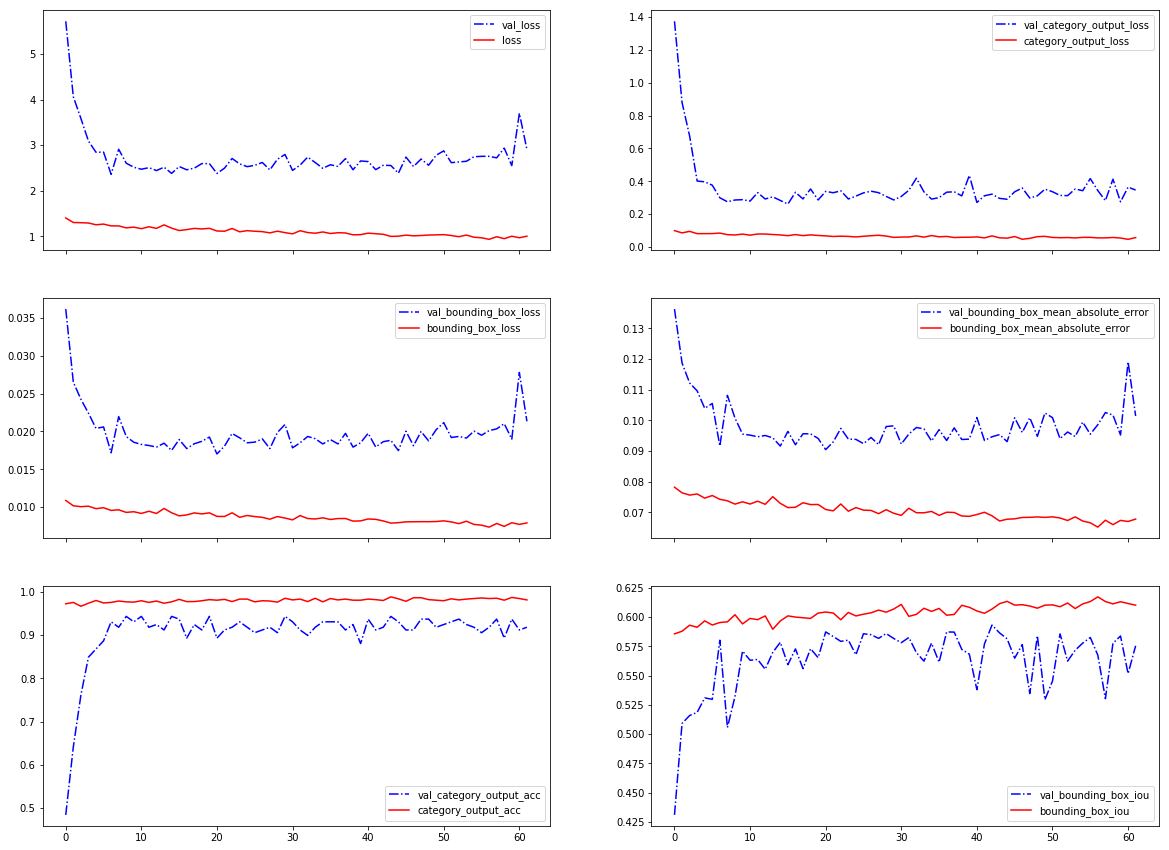

Epoch 63/2000
17/25 [===================>..........] - ETA: 3s - loss: 0.9658 - category_output_loss: 0.0528 - bounding_box_loss: 0.0076 - category_output_acc: 0.9835 - bounding_box_iou: 0.6091 - bounding_box_mean_absolute_error: 0.0664

In [ ]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=2000,
        validation_data=val_generator_multiple_outputs, callbacks = [plot_losses, checkpoint]
        )

In [1092]:
model.evaluate_generator(val_generator_multiple_outputs)

[3.040785789489746,
 0.47845780849456787,
 0.02135273441672325,
 0.9056603908538818,
 0.5680345296859741,
 0.09946852922439575]

In [1093]:
model.evaluate_generator(train_generator_multiple_outputs)

[1.0670404583596818,
 0.15426425719657516,
 0.0076064683361183804,
 0.933503836164694,
 0.6113303715310743,
 0.06651180673895589]

In [223]:
#model.save_weights('weights_5_classes_w_30_final_1000_epochs.hdf5')

# Testeo

In [1094]:
model.load_weights('weights_5_classes_w_30_best_after_final_1000_epochs_do_25.hdf5')

In [1095]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 64, flip='never')
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, val_folder, 159, flip='never')

Found 1564 images belonging to 5 classes.
Found 159 images belonging to 5 classes.


In [1096]:
model.evaluate_generator(val_generator_multiple_outputs)

[2.553290843963623,
 0.2905297577381134,
 0.018856342881917953,
 0.9371069073677063,
 0.5751515626907349,
 0.09429743140935898]

In [1097]:
model.evaluate_generator(train_generator_multiple_outputs)

[1.5417180793059757,
 0.21840832277637004,
 0.011027581358561888,
 0.908567775088503,
 0.5825600787196927,
 0.07870321562680442]

In [1098]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 64, flip='never', get_filenames = True)
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, val_folder, 159, flip='never', get_filenames = True)

Found 1564 images belonging to 5 classes.
Found 159 images belonging to 5 classes.


In [1099]:
index_to_class = {v:k for k,v in val_generator_multiple_outputs.generator.class_indices.items()}
print(index_to_class)

{0: 'n01751748', 1: 'n02108089', 2: 'n02279972', 3: 'n02701002', 4: 'n04487081'}


In [1100]:
data_to_predict = next(val_generator_multiple_outputs)
images_batch = data_to_predict[0]
predictions_batch = model.predict_on_batch(images_batch)

In [1101]:
def getBB_area(bb):
    IntersectionArea = (bb[:,2] - bb[:,0])*(bb[:,3] - bb[:,1])
    return IntersectionArea

In [1102]:
def getIUO(bb1, bb2):
    intersection_bb = np.array([np.vstack([bb1[:,0], bb2[:,0]]).max(axis=0),
        np.vstack([bb1[:,1], bb2[:,1]]).max(axis=0),
        np.vstack([bb1[:,2], bb2[:,2]]).min(axis=0),
        np.vstack([bb1[:,3], bb2[:,3]]).min(axis=0)]).T
    no_intersec = 1*(intersection_bb[:,3]-intersection_bb[:,1]>0)*(intersection_bb[:,2]-intersection_bb[:,0]>0)
    intersection_bb = (intersection_bb.T * no_intersec).T
    #if intersection_bb[1]>intersection_bb[3] or intersection_bb[0]>intersection_bb[2]:
    #    return 0, [0,0,0,0]
    IntersectionArea = no_intersec*getBB_area(intersection_bb)
    IOU = IntersectionArea/(getBB_area(bb1) + getBB_area(bb2) - IntersectionArea)
    return IOU, intersection_bb

In [1103]:
bounding_boxes_norm = data_to_predict[1][1]
bounding_boxes = np.array([
    bounding_boxes_norm[:,0] - bounding_boxes_norm[:,2]/2, 
 bounding_boxes_norm[:,1] - bounding_boxes_norm[:,3]/2,
 bounding_boxes_norm[:,0] + bounding_boxes_norm[:,2]/2, 
 bounding_boxes_norm[:,1] + bounding_boxes_norm[:,3]/2,]).T

In [1104]:
bounding_boxes_norm_pred = predictions_batch[1]
bounding_boxes_pred = np.array([
    bounding_boxes_norm_pred[:,0] - bounding_boxes_norm_pred[:,2]/2, 
 bounding_boxes_norm_pred[:,1] - bounding_boxes_norm_pred[:,3]/2,
 bounding_boxes_norm_pred[:,0] + bounding_boxes_norm_pred[:,2]/2, 
 bounding_boxes_norm_pred[:,1] + bounding_boxes_norm_pred[:,3]/2,]).T

In [1105]:
IOUs, inters_bb = getIUO(bounding_boxes, bounding_boxes_pred)

In [1106]:
IOUs.mean(), IOUs.std()
# (0.5631567499343189, 0.2076387409772741)

(0.5751515608526876, 0.2250877355898847)

Pred class:  trolleybus, trolley coach, trackless trolley
Grund Truph: trolleybus, trolley coach, trackless trolley
IOU: [0.83801399]


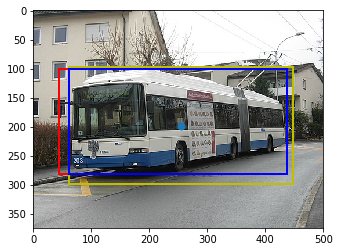

Pred class:  monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Grund Truph: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
IOU: [0.61923845]


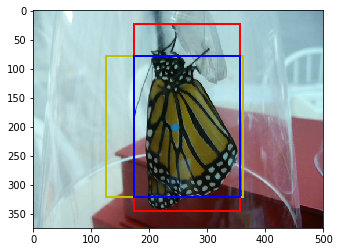

Pred class:  monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Grund Truph: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
IOU: [0.51446268]


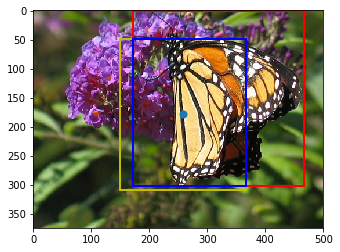

Pred class:  trolleybus, trolley coach, trackless trolley
Grund Truph: trolleybus, trolley coach, trackless trolley
IOU: [0.56009921]


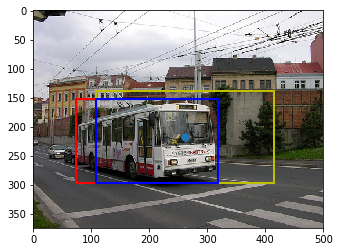

Pred class:  sea snake
Grund Truph: sea snake
IOU: [0.13650322]


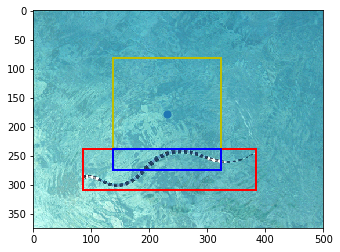

Pred class:  monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Grund Truph: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
IOU: [0.67147737]


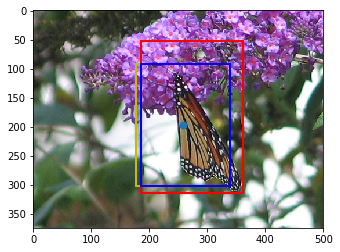

Pred class:  boxer
Grund Truph: boxer
IOU: [0.40913834]


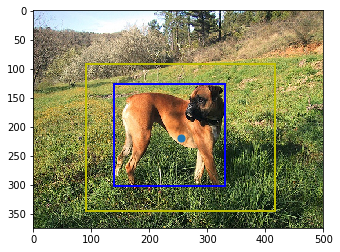

Pred class:  boxer
Grund Truph: boxer
IOU: [0.69919781]


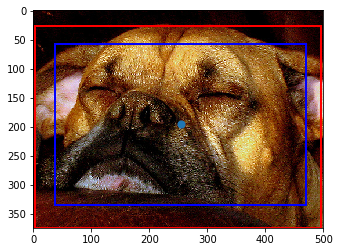

Pred class:  monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Grund Truph: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
IOU: [0.73220376]


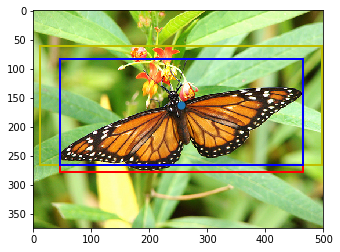

Pred class:  ambulance
Grund Truph: ambulance
IOU: [0.80261896]


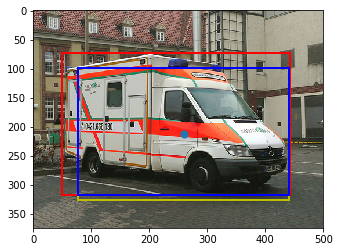

In [1107]:
no_iou_indexes = np.where(IOUs==0)
for i in range(10):
    f, ax = plt.subplots(1,1)
    prediction_index = i + 30
    predicted_class_name = synset_dict[index_to_class[np.argmax(predictions_batch[0][prediction_index])]]
    ground_truth_class_id = data_to_predict[2][prediction_index].split('/')[0]
    filename = data_to_predict[2][prediction_index].split('/')[1]
    ground_truth_class_name = synset_dict[ground_truth_class_id]
    print('Pred class: ', predicted_class_name)
    print('Grund Truph:',ground_truth_class_name)
    bounding_box = annotations_dict_val[ground_truth_class_id][filename.split('.')[0]]['bounding_boxes'][0]
    im_w = images_batch[prediction_index].shape[1]
    im_h = images_batch[prediction_index].shape[0]
    centerX = predictions_batch[1][prediction_index][0]
    centerY = predictions_batch[1][prediction_index][1]
    width = predictions_batch[1][prediction_index][2]
    height = predictions_batch[1][prediction_index][3]
    
    predicted_bounding_box = [((centerX-width/2)*im_w), ((centerY-height/2)*im_h), ((centerX+width/2)*im_w), ((centerY+height/2)*im_h)]
    ax.imshow(images_batch[prediction_index])
    ax.scatter(centerX*im_w, centerY*im_h, s= 50)
    rect = patches.Rectangle(predicted_bounding_box[:2],
                                predicted_bounding_box[2]-predicted_bounding_box[0],
                                predicted_bounding_box[3]-predicted_bounding_box[1],
                                linewidth=2, edgecolor='y',facecolor='none')
    ax.add_patch(rect)
    rect_gt = patches.Rectangle(bounding_box[:2],
                                bounding_box[2]-bounding_box[0],
                                bounding_box[3]-bounding_box[1],
                                linewidth=2, edgecolor='r',facecolor='none')
    ax.add_patch(rect_gt)
    IOU, intersection_bb = getIUO(np.array([predicted_bounding_box]), np.array([bounding_box]))
    intersection_bb = intersection_bb[0]
    rect_int = patches.Rectangle(intersection_bb[:2],
                                intersection_bb[2]-intersection_bb[0],
                                intersection_bb[3]-intersection_bb[1],
                                linewidth=2, edgecolor='b',facecolor='none')
    ax.add_patch(rect_int)
    
    print('IOU:',IOU)
    plt.show()